<a href="https://colab.research.google.com/github/aachen6/deepTC/blob/master/colab/deepTC_classification_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeepTC - Resnet

The objective of *deepTC* can be found on [deepTC github page](https://github.com/aachen6/deepTC/), and the analysis is outlined below.
1. Data Preprocess
 - 1.1 [Satellite images and tracks of TC](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_images_tracks_sync.ipynb)
 - 1.2 [Statistics of satellite images and tracks](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_images_tracks_stats.ipynb)

2. Model for TC Image
 - 2.1 [Post-binding architecture of TC image](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_net_image.ipynb)
 - 2.2 [CNN model for TC image classification ](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_classification_cnn5.ipynb)
 - **2.3 [Resnet model for TC image classification](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_classification_resnet.ipynb)**
 - 2.4 [Resnet model for TC image intensity estimation](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_intensity_resnet.ipynb)
 - 2.5 [Operation of TC image prediction](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_image_prediction.ipynb)

3. Model for TC Track
 - 3.1 [Post-binding architecture of TC track](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_net_track.ipynb)
 - 3.2 [LSTM model for TC track prediction](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_track_lstm.ipynb)
 - 3.3 [LSTM model with attension for TC track prediction](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_track_lstm.ipynb) 
 - 3.4 [LSTM-CNN model for TC track prediction](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_track_lstmcnn.ipynb)

4. Generative Model for TC Image
 - 4.1 [DCGAN model for deepTC](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_generative_dcgan.ipynb)
 - 4.2 [SAGAN model for deepTC](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_generative_sagan.ipynb)

In the [previous notebook](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_cnn5_classification.ipynb), we demonstrated the implementation and training of a five-layer convolution network for the classification of the TC satellite images and achieved a test accuray of 96.3%. It is possible to design a different convolution architecture, e.g. deep layers and/or with larger channels, to improve the model accuracy. The accuary may be saturated or even degenerated due to notorious vanishing gradient problem. Therefore, let's turn to a different concept in this notebook for the classification of the TC satellite images, i.e. residual net. The purpose is to demonstrate i) how a different architecture can be easily implemented using the system we developed so far; ii) the performance of the residual net with the same depth for the same problem. As usual, let's start with importing the necessary python modules,  reusing our previous notebooks by installing *import-ipynb*, and mounting *Google Drive* access the processed dataset. 

In [0]:
!pip install import-ipynb

In [0]:
import os 
import yaml
import numpy as np
import pandas as pd

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

work_dir = r'/content/drive/My Drive/Colab Notebooks/deepTC'
p_data  = work_dir + os.sep + 'data/AL'
p_image = work_dir + os.sep + 'image/AL'
p_class = work_dir + os.sep + 'model/tc_classification'
p_model = p_class + os.sep + 'resnet'

# load class defined in other ipynb
import import_ipynb
model_ipynb = work_dir + os.sep + 'deepTC_net_image.ipynb'
with open(model_ipynb, 'rb') as fp:
    with open('deepTC_net_lib.ipynb','wb') as fout:
       fout.write(fp.read())
  
import deepTC_net_lib
# force reload in case of changes
#import importlib
#importlib.reload(deepTC_net_lib)
from deepTC_net_lib import YML2ModelNet, ImageDataSet, ImageTrainer, ImageInference


##ResNet

For simple sequentially stacking layers of deep neutral network,  repeated multiplication through the back-propagation may make the gradient infinitively small at earlier layers, causing the notorious vanishing gradient problem. As the network depth increases, the performance is not monotonically enhancing and may get saturated or even degrading rapidly. ResNet was firstly introduced in [this paper](https://arxiv.org/pdf/1512.03385.pdf) in 2015 by Microsoft research team to overcome this problem. In a nutshell, deep residual network is an architecture that fits a residual mapping rather than the underlying mapping by carrying the input to the output within a building block (residual block), and recast the underlying mapping as the summation of the input and the output from the original mapping, as shown in figure below.

![residual block](https://cdn-images-1.medium.com/max/750/1*ByrVJspW-TefwlH7OLxNkg.png) *Image Credit: [https://arxiv.org/pdf/1512.03385.pdf](https://arxiv.org/pdf/1512.03385.pdf)*

###Network Architecture
As compared with the *CNN5 net* developed in the [previous notebook](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_cnn5_classification.ipynb), the only thing that needs be updated to implement the *Resnet* is to revise the network architecture in the configuration file. Similary, the first layer maps one channel greyscale images into 32 channels with 32 5 x 5 filters and reduces the feature map size by a factor of four using *maxpool2d* function with stride of 2. As compared with *CNN5 net*, this is followed by two residual blocks, and each has one convolution layer that doubles the channel size and one with constant channel size. *ReLU* is applied after the summation of the identity mapping and residual mapping. The *avgpool2d* with reduction of 16 is applied following the last convolution layer. The last two layer is the same as that in the *CNN5 net*, which transforms the feature space into a vector of 7 corresponding to the number of classes. Please note other than the different network architecture, this is not an apple to apple comparison as pooling is not used to reduce the feature size in the resnet block as suggested in the original [resnet paper](https://arxiv.org/pdf/1512.03385.pdf). The overall number of parameter is therefore larger than that from the *CNN5 net*.  

<img src='https://raw.githubusercontent.com/aachen6/deepTC/master/model/tc_classification/resnet/resnet.png' width='800'/>

The same dataset used for *CNN5 net* is used here for consistency, which has a separation ration of 72:18:10 among training, validation, and testing set. Similarly, *Cross-Entropy* loss with *Adam* optimizer are used with the default learning rate &eta;=0.001 and momentum parameters (&beta;<sub>1</sub>=0.9, &beta;<sub>2</sub>=0.999). We also trained the model for 15 epochs with a batch size of 64. The loss and accuracy of each batch and epoch (running average) are generated and updated in the plot below during the training and validation process. Even with the same deep, the *Resnet* achieves a best validation accuary of 97.2%, which is slightly better than its counterpart *CNN5* model. Although this statement is not entirely accurate as there is randomness in the prediction accuray due to model parameters initialization andl optimization process, the true benefit of *Resnet* is that it allows much deeper network without suffering vanishing gradient problem therefore allowing more complex model to be trained to achieve better accuarcy. This notebook simply demonstrates the implementation with this free resource, therefore much deeper *Resnet* is not tested.

###Training and Validation

In [0]:
import torch
from torchvision.transforms import transforms

torch.cuda.empty_cache()

# load configuration file
f_config = p_model + os.sep + 'config_resnet.yaml'
with open(f_config, 'r') as fp: config = yaml.load(fp)

# contruct the model
storm_resnet = YML2ModelNet(config, 'resnet')

# update path for config
config_params = config['params']
config_params['f_image_zip'] = p_image + os.sep + config_params['f_image_zip']
config_params['f_storm_msg'] = p_data  + os.sep + config_params['f_storm_msg']
config_params['f_data_yml']  = p_class + os.sep + config_params['f_data_yml']
config_params['f_state_yml'] = p_model + os.sep + config_params['f_state_yml']
config_params['f_model_pth'] = p_model + os.sep + config_params['f_model_pth']
config_params['f_test_yml']  = p_model + os.sep + config_params['f_test_yml']


# normalization is based on ramdon 1000 samples for this test
image_transforms = transforms.Compose([
    transforms.Grayscale(1),
    transforms.ToTensor(),
    transforms.Normalize((0.456,), (0.222,))])


# dataset
storm_data = ImageDataSet(config_params, image_transforms, hotstart=True)
data_split = storm_data.load_data()

# model
storm_train = ImageTrainer(config_params, storm_resnet, hotstart=False)

# train & valid
storm_train.train_loop(data_split)

# test
test_results = storm_train.test_loop(data_split)


------------------------------------
summary of dataset
------------------------------------
               train     valid      test
percent         0.72      0.18      0.10
size           34944      8742      4857
batch            546       136        75
------------------------------------
summary of GPU
------------------------------------
Tesla K80
Memory Usage:
Allocated: 0.1 GB
Cached:    0.1 GB
------------------------------------
training
------------------------------------


------------------------------------
summary of epoch: 0
------------------------------------
loss -           train     valid
                 1.030     0.708
accuracy/error - 
                61.424    74.310
 


------------------------------------
summary of epoch: 1
------------------------------------
loss -           train     valid
                 0.540     0.510
accuracy/error - 
                80.990    82.726
 


------------------------------------
summary of epoch: 2
------------------------------------
loss -           train     valid
                 0.300     0.331
accuracy/error - 
                90.033    88.651
 


------------------------------------
summary of epoch: 3
------------------------------------
loss -           train     valid
                 0.175     0.192
accuracy/error - 
                94.408    94.149
 


------------------------------------
summary of epoch: 4
------------------------------------
loss -           train     valid
                 0.118     0.194
accuracy/error - 
                96.389    94.407
 


------------------------------------
summary of epoch: 5
------------------------------------
loss -           train     valid
                 0.088     0.148
accuracy/error - 
                97.118    96.358
 


------------------------------------
summary of epoch: 6
------------------------------------
loss -           train     valid
                 0.072     0.171
accuracy/error - 
                97.630    95.768
 


------------------------------------
summary of epoch: 7
------------------------------------
loss -           train     valid
                 0.060     0.150
accuracy/error - 
                98.106    96.856
 


------------------------------------
summary of epoch: 8
------------------------------------
loss -           train     valid
                 0.046     0.204
accuracy/error - 
                98.429    95.894
 


------------------------------------
summary of epoch: 9
------------------------------------
loss -           train     valid
                 0.048     0.177
accuracy/error - 
                98.455    95.875
 


------------------------------------
summary of epoch: 10
------------------------------------
loss -           train     valid
                 0.041     0.179
accuracy/error - 
                98.709    96.350
 


------------------------------------
summary of epoch: 11
------------------------------------
loss -           train     valid
                 0.033     0.166
accuracy/error - 
                98.930    97.160
 


------------------------------------
summary of epoch: 12
------------------------------------
loss -           train     valid
                 0.044     0.161
accuracy/error - 
                98.586    96.901
 


------------------------------------
summary of epoch: 13
------------------------------------
loss -           train     valid
                 0.020     0.239
accuracy/error - 
                99.307    95.822
 


------------------------------------
summary of epoch: 14
------------------------------------
loss -           train     valid
                 0.041     0.168
accuracy/error - 
                98.646    97.065
 
------------------------------------
summary of test
------------------------------------
               total  accuracy
test            4857    97.099


###Test Performance

On the test of the optimized model, the overall test accuracy is 97.1% with a 0.8% improvement from the *CNN5 net*. The confusion matrix below also shows that the model performs well for classes with much less samples, indicating the model is not sensitive to such imbalance in the sample classes. The prediction of the class with the least sample achieves even better accuarcy of 98.2% than the overall accuracy of 97.1%.

------------------------------------
summary of test
------------------------------------
               total  accuracy
test            4857    97.097


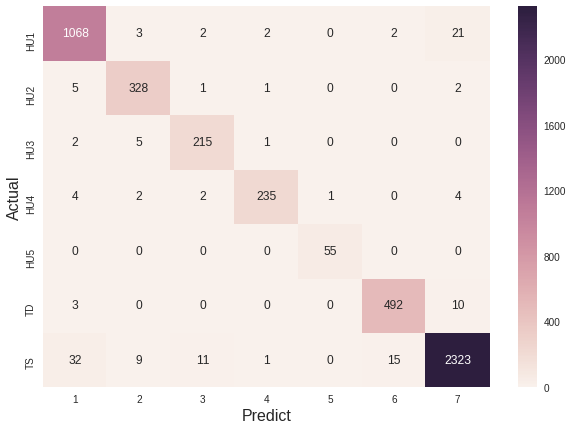

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# load configuration file
f_config = p_model + os.sep + 'config_resnet.yaml'
with open(f_config, 'r') as fp: config = yaml.load(fp)
  
# update path for config
config_params = config['params']
config_params['f_image_zip'] = p_image + os.sep + config_params['f_image_zip']
config_params['f_storm_msg'] = p_data  + os.sep + config_params['f_storm_msg']
config_params['f_data_yml']  = p_class + os.sep + config_params['f_data_yml']
config_params['f_state_yml'] = p_model + os.sep + config_params['f_state_yml']
config_params['f_model_pth'] = p_model + os.sep + config_params['f_model_pth']
config_params['f_test_yml']  = p_model + os.sep + config_params['f_test_yml']

f_data_yml = config_params['f_data_yml']
with open(f_data_yml, 'rb') as fp: data = yaml.load(fp)

f_test = config_params['f_test_yml']
with open(f_test, 'r') as fp: test_results = yaml.load(fp)
test_idxs = test_results['idxs']
#test_idxs = test_idxs.detach().numpy()
test_labels = test_results['labels']
test_predicts = test_results['predicts']
   
# check test data, for debug purpose to make sure test dataset is correct
# f_img_msg = p_data + os.sep + 'al_ir_track_filtered.msg'
# pd_storm = pd.read_msgpack(f_img_msg) 
# print(len(test_labels))
# print(len(pd_storm.iloc[test_indices].index))
# print(pd_storm.iloc[test_indices].groupby(b'cat').count())
# print(np.unique(test_labels, return_counts=True))

# test summary
n_correct = np.equal(test_predicts, test_labels).sum().item()
accuracy = n_correct / len(test_labels) * 100.
divider = '-' * 36
print(divider)
print('summary of test')
print(divider)
print('{:<10s}{:>10s}{:>10s}'.format('', 'total', 'accuracy'))
print('{:<10s}{:>10d}{:>10.3f}'.format('test', len(test_labels), accuracy))   
        

# confusion matrix
cfx = confusion_matrix(test_labels, test_predicts)
df_cfx = pd.DataFrame(cfx, index = [one_hot_rev[i] for i in range(7)], 
                           columns = [str(i+1) for i in range(7)])

fig, ax = plt.subplots(figsize = (10,7))
sns.heatmap(df_cfx, annot=True, annot_kws={'size': 12}, fmt='d', ax=ax)
ax.set_xlabel('Predict',fontsize=16)
ax.set_ylabel('Actual',fontsize=16)

# true_to_false
true_to_false = {} # miss-classified images
for i in range(7): true_to_false[one_hot_rev[i]] = []
for i, (x, y) in enumerate(zip(test_labels, test_predicts)):
    if x==y: continue
    true_cat = one_hot_rev[x]
    false_cat = one_hot_rev[y]
    true_to_false[true_cat].append([test_idxs[i], false_cat])
    